## Mask R-CNN - BEP Model

Tensorflow and CUDA compatibility: https://github.com/tensorflow/docs/blob/master/site/en/install/source.md

This maybe also works:  tensorflow-2.4.0 with cuda-11.1 and cudnn 8.0.5.

### **Imports**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import tensorflow as tf # type: ignore
import matplotlib.pyplot as plt # type: ignore 

ROOT_DIR = os.path.abspath("../../")

sys.path.append(ROOT_DIR)
from mrcnn import utils
from mrcnn import visualize
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 

MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, 'weights', 'graphene_mask_rcnn_tdm_0120.h5')
# COCO_MODEL_PATH = os.path.join(ROOT_DIR, 'weights', 'ensemble_mask_rcnn_tdm_0120.h5')

Using TensorFlow backend.


In [2]:
%load_ext autoreload
%autoreload 2
import bep_data
import bep_utils

### **Configurations**

In [3]:
import tdmcoco
config = tdmcoco.CocoConfig()


class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 3  # thin, few, thick
    DETECTION_MIN_CONFIDENCE = 0.7
config = InferenceConfig()
# config.display()

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

def get_ax(rows=1, cols=1, size=20):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

### **Load data**

In [4]:
bep_utils.check_dir_setup(ROOT_DIR, 0.7)

train = bep_data.bepDataset()
train.load_dir(os.path.join(ROOT_DIR, 'data'), 'train', reload_annotations=True)
train.prepare()

original = tdmcoco.CocoDataset()
original.load_coco(os.path.join(ROOT_DIR, 'DL_2DMaterials', 'Dataset_DL_2DMaterials', 'Graphene'), 'train')
original.prepare()

print("Train images: {} | Classes: {}".format(len(train.image_ids), train.class_names))
print("Original images: {} | Classes: {}".format(len(original.image_ids), original.class_names))

Directory setup correctly
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
Train images: 14 | Classes: ['BG', 'Mono_Graphene', 'Few_Graphene', 'Thick_Graphene']
Original images: 679 | Classes: ['BG', 'Mono_Graphene', 'Few_Graphene', 'Thick_Graphene']


### **Load Model for inference**

In [5]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

weights_path = COCO_MODEL_PATH
# Or, uncomment to load the last model you trained
# weights_path = model.find_last()

print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights  c:\Users\abell\Documents\aa_delft\J4\BEP\ai\weights\graphene_mask_rcnn_tdm_0120.h5








### **Run Model**

In [6]:
# image_id = random.choice(dataset_bep.image_ids)
image_id = original.image_ids[0]
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(original, config, image_id, use_mini_mask=False)

info = original.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, original.image_reference(image_id)))

image ID: coco.cju83b3ehjqxc08719ad9v29m (0) http://cocodataset.org/#explore?id=cju83b3ehjqxc08719ad9v29m


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  138.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (12,)                 min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (12, 4)               min:  219.00000  max:  728.00000  int32
gt_mask                  shape: (1024, 1024, 12)      min:    0.00000  max:    1.00000  bool


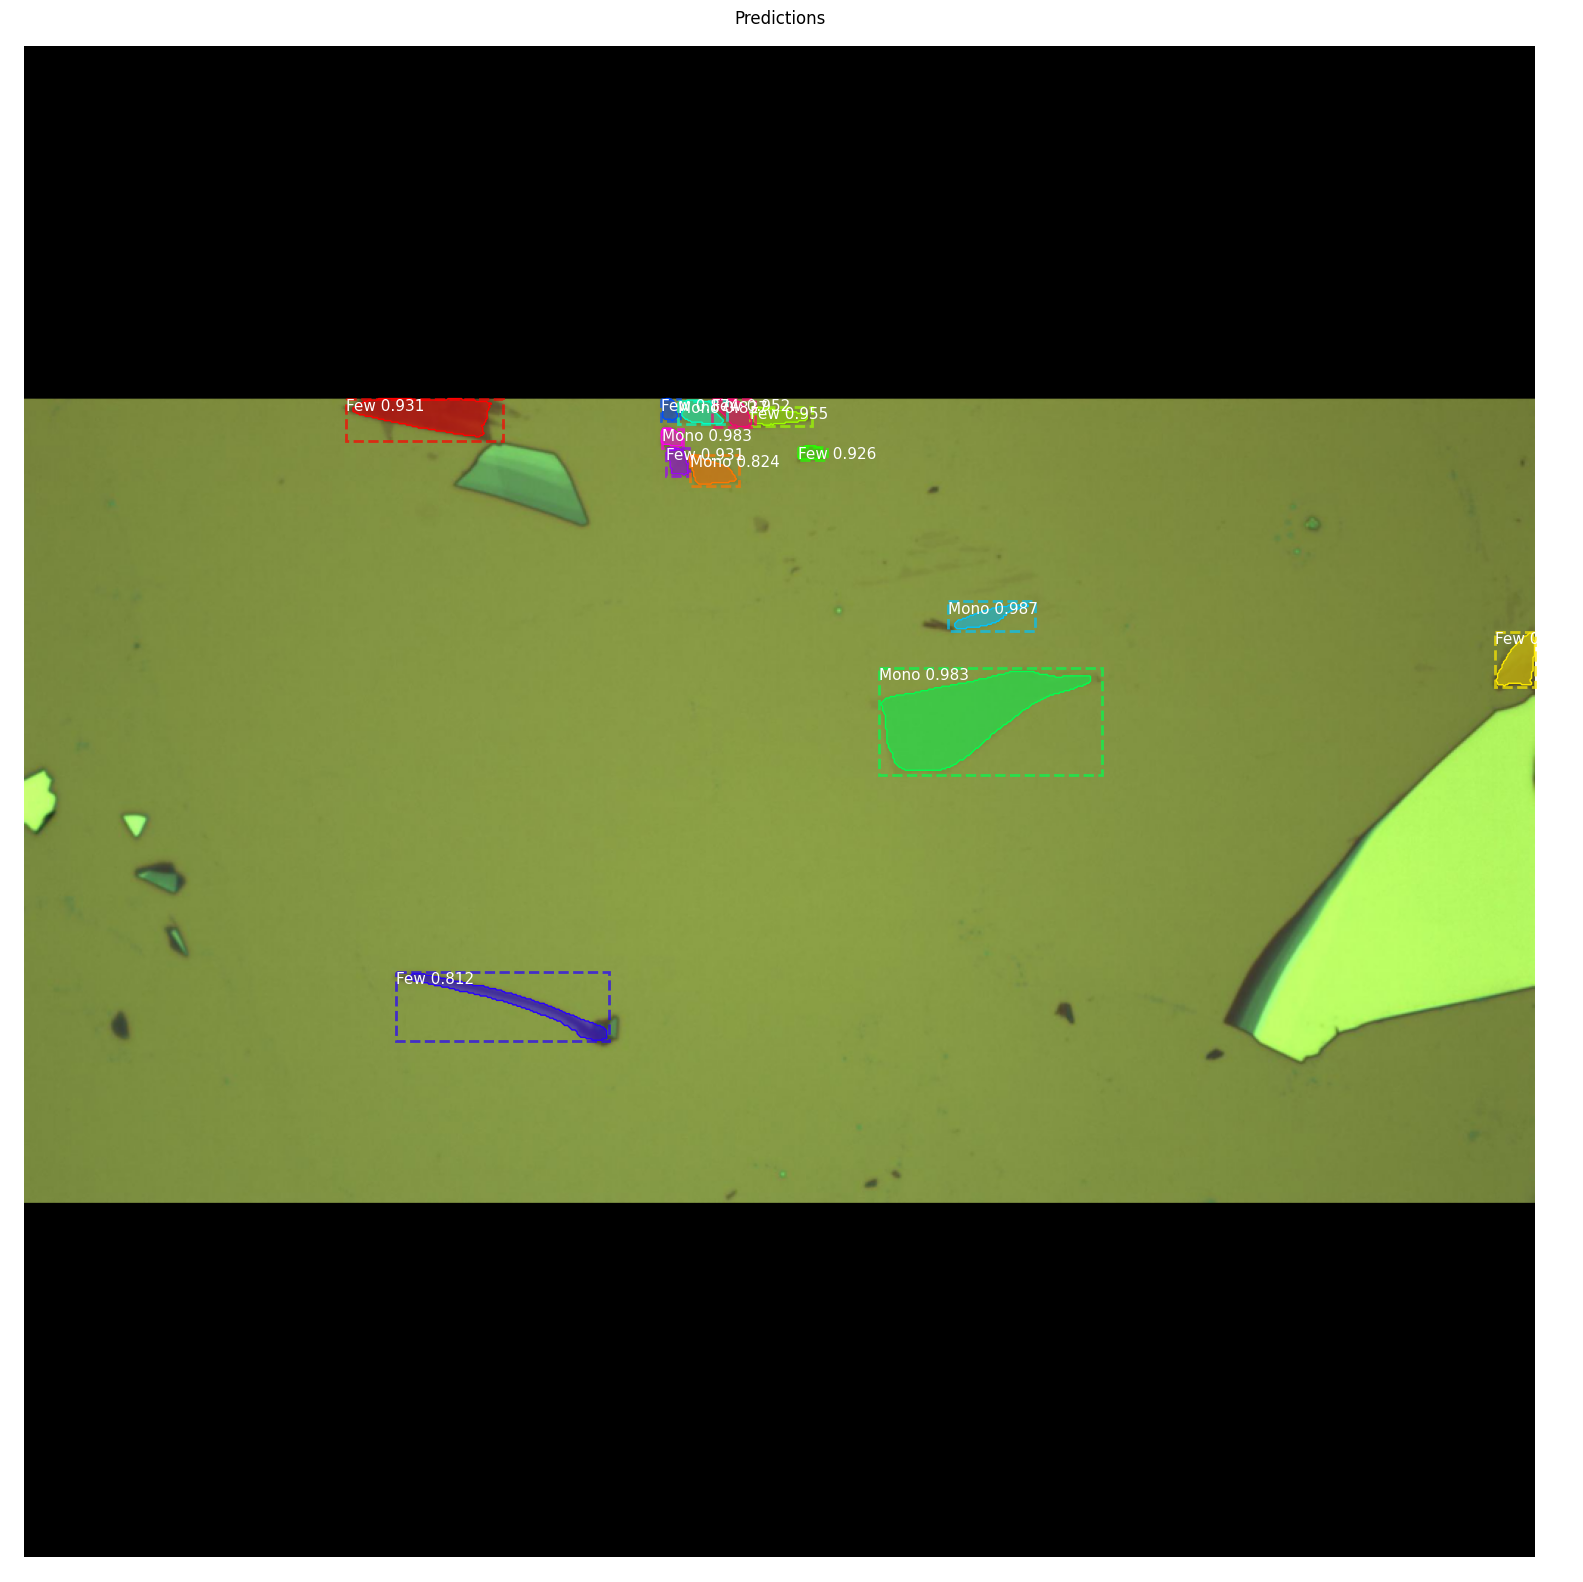

In [7]:
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            ['','Mono', 'Few','Thick'], r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

### Ground Truth

image_id:  0 http://cocodataset.org/#explore?id=cju83b3ehjqxc08719ad9v29m
Original shape:  (1086, 2040, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1024, 1024, 12)      min:    0.00000  max:    1.00000  bool
class_ids                shape: (12,)                 min:    1.00000  max:    2.00000  int32
[1 1 1 1 1 2 2 2 2 2 2 2]
bbox                     shape: (12, 4)               min:  219.00000  max:  728.00000  int32


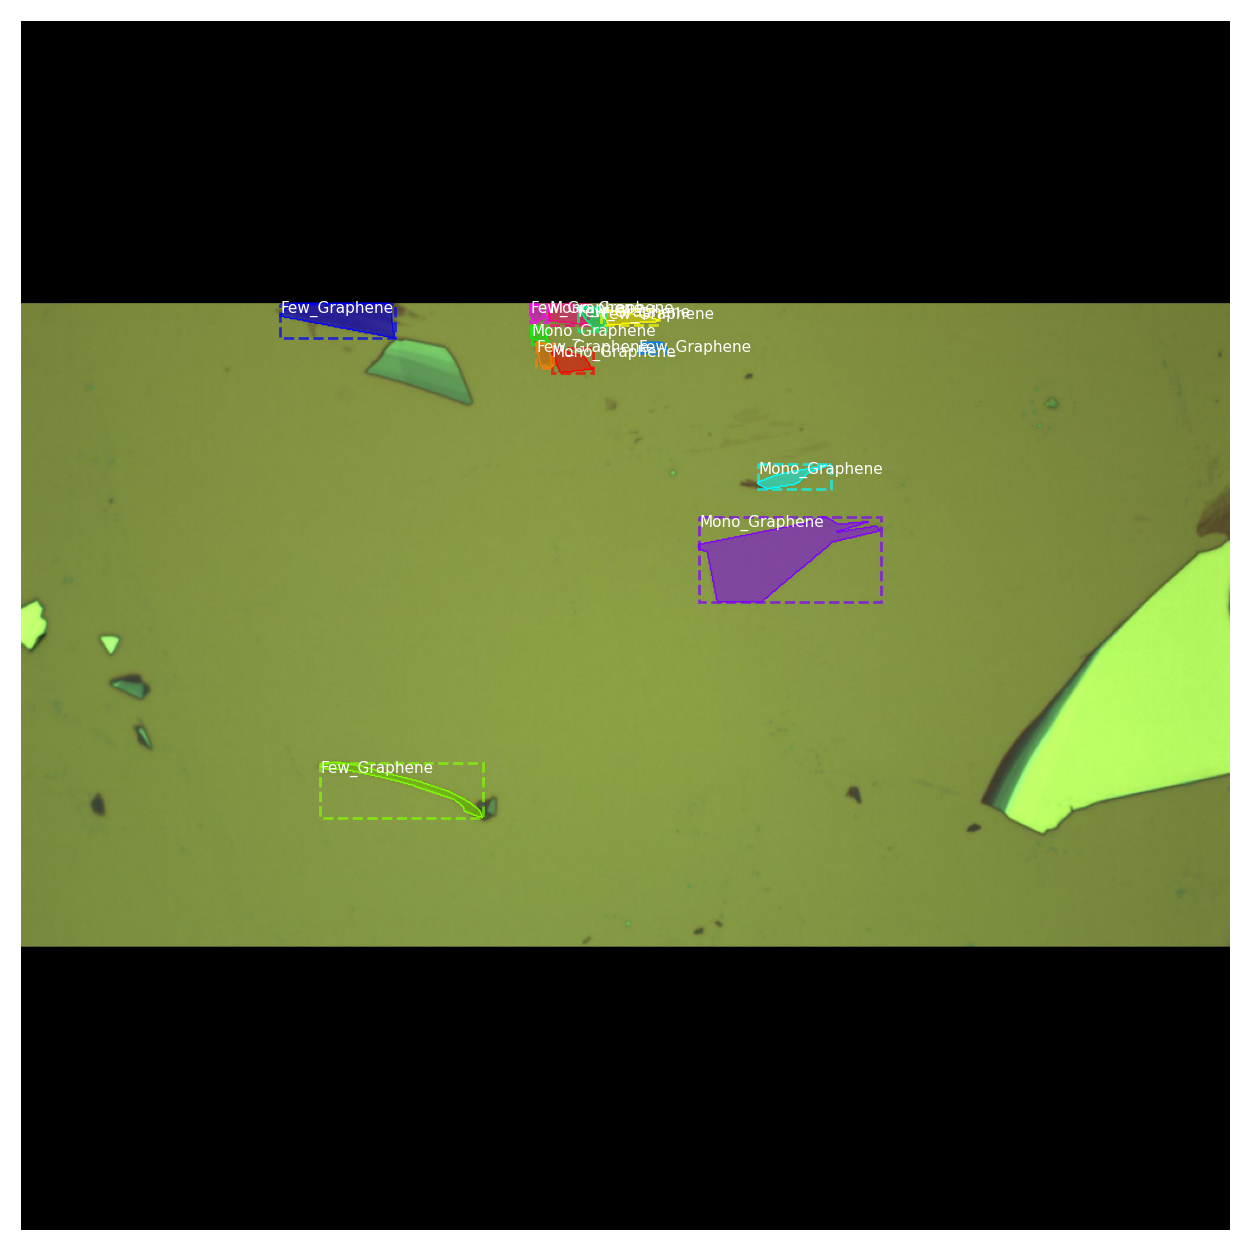

In [8]:
image = original.load_image(image_id)
mask, class_ids = original.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, original.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
print(class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, original.class_names)